In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar
from pandas.tseries.offsets import MonthEnd
import scipy.stats as st

### Part 1 - Import the data, and ensure that stuff is formatted in a roughly appropriate manner

In [2]:
inflation_index=pd.read_excel('./datasets/BLS_CPIU_SeasonallyAdjusted.xlsx',header=11,usecols="A:M")
inflation_index.head()
#Note: 1982-84 sets the value of 100 for CPI-U index
#Note: using Seasonally Adjusted CPI-U index here - should make month-to-month swings lower

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1996,154.7,155.0,155.5,156.1,156.4,156.7,157.0,157.2,157.7,158.2,158.7,159.1
1,1997,159.4,159.7,159.8,159.9,159.9,160.2,160.4,160.8,161.2,161.5,161.7,161.8
2,1998,162.0,162.0,162.0,162.2,162.6,162.8,163.2,163.4,163.5,163.9,164.1,164.4
3,1999,164.7,164.7,164.8,165.9,166.0,166.0,166.7,167.1,167.8,168.1,168.4,168.8
4,2000,169.3,170.0,171.0,170.9,171.2,172.2,172.7,172.7,173.6,173.9,174.2,174.6


In [3]:
#Melting the dataframe to get one row per monthly entry
inflation_df=inflation_index.melt(id_vars=['Year'],var_name='Mon',value_name='CPI_U')
inflation_df.head()

,Year,Mon,CPI_U
0,1996,Jan,154.7
1,1997,Jan,159.4
2,1998,Jan,162.0
3,1999,Jan,164.7
4,2000,Jan,169.3


In [4]:
print(inflation_df.Mon.unique())
print(inflation_df.CPI_U.max())
print(inflation_df.CPI_U.min())
inflation_df.dropna(inplace=True) #Dropping Nov - Dec 2020 where there is, as of now, no data available
print(inflation_df.shape)

['Jan' 'Feb' 'Mar' 'Apr' 'May' 'Jun' 'Jul' 'Aug' 'Sep' 'Oct' 'Nov' 'Dec']
260.325
154.7
(298, 3)


In [5]:
#Create a pandas datetime from the index so that it's ready to merge
month_num_dict={month: index for index, month in enumerate(calendar.month_abbr) if month}
from pandas.tseries.offsets import MonthEnd

inflation_df['Day']=np.ones(inflation_df.shape[0])
inflation_df['Month']=inflation_df['Mon'].map(month_num_dict)
#print(inflation_df.dtypes)
inflation_df['YearMo']=pd.to_datetime(inflation_df[['Year','Month','Day']])+MonthEnd(1)
inflation_df.sort_values('YearMo',inplace=True)
print(inflation_df.YearMo.max())
print(inflation_df.YearMo.min())
print(inflation_df.dtypes)
inflation_df.head()
inflation_df.tail()
#Inflation index is ready for merging!

2020-10-31 00:00:00
1996-01-31 00:00:00
Year               int64
Mon               object
CPI_U            float64
Day              float64
Month              int64
YearMo    datetime64[ns]
dtype: object


,Year,Mon,CPI_U,Day,Month,YearMo
149,2020,Jun,257.214,1.0,6,2020-06-30
174,2020,Jul,258.723,1.0,7,2020-07-31
199,2020,Aug,259.681,1.0,8,2020-08-31
224,2020,Sep,260.209,1.0,9,2020-09-30
249,2020,Oct,260.325,1.0,10,2020-10-31


In [6]:
#Part 2 - import the zillow home price data
home_data=pd.read_csv('./datasets/Zillow_ZHVI_MSA_.csv')
home_data.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,...,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31
0,102001,0,United States,Country,NaN,107592.0,107619.0,107670.0,107796.0,107940.0,...,248440.0,249439.0,250595.0,251849.0,253057.0,254320.0,255845.0,257804.0,260091.0,262604.0
1,394913,1,"New York, NY",Msa,NY,188871.0,188430.0,188149.0,187613.0,187294.0,...,483191.0,484139.0,485177.0,486507.0,488000.0,489895.0,492468.0,495908.0,500412.0,505569.0
2,753899,2,"Los Angeles-Long Beach-Anaheim, CA",Msa,CA,185474.0,185732.0,185752.0,185860.0,185834.0,...,680279.0,685435.0,690691.0,695044.0,696786.0,698190.0,702883.0,710534.0,718779.0,726379.0
3,394463,3,"Chicago, IL",Msa,IL,164098.0,163797.0,163399.0,162948.0,162342.0,...,244738.0,245092.0,245678.0,246204.0,246794.0,247545.0,248846.0,250588.0,252917.0,255532.0
4,394514,4,"Dallas-Fort Worth, TX",Msa,TX,113386.0,113451.0,113613.0,113937.0,114286.0,...,258147.0,258784.0,259781.0,260955.0,262153.0,263579.0,265256.0,267187.0,269202.0,271831.0


In [7]:
#Explore the data a little bit, before melting it
print(home_data.RegionType.unique())
print(home_data.StateName.unique())
print(home_data.StateName.unique().shape) #All 50 states, plus DC and nan
print(home_data.shape) #913 MSA's plus the overall country represented
home_data.drop(['StateName'],axis=1).isnull().any() #Looks like not all metros have all data - some missing in 1996-01-31

['Country' 'Msa']
[nan 'NY' 'CA' 'IL' 'TX' 'PA' 'DC' 'FL' 'GA' 'MA' 'MI' 'AZ' 'WA' 'MN' 'MO'
 'MD' 'CO' 'OR' 'NC' 'OH' 'NV' 'IN' 'VA' 'TN' 'RI' 'WI' 'OK' 'KY' 'CT'
 'LA' 'AL' 'UT' 'HI' 'NM' 'NE' 'SC' 'AR' 'KS' 'ID' 'IA' 'MS' 'ME' 'NH'
 'AK' 'DE' 'NJ' 'WV' 'SD' 'VT' 'ND' 'MT' 'WY']
(52,)
(914, 303)


RegionID      False
SizeRank      False
RegionName    False
RegionType    False
1996-01-31     True
              ...  
2020-06-30    False
2020-07-31    False
2020-08-31    False
2020-09-30    False
2020-10-31    False
Length: 302, dtype: bool

In [8]:
#Melt the data to get one entry per MSA per month
trend_data=home_data.melt(id_vars=['RegionType','RegionName','SizeRank','StateName','RegionID'],value_name='ZHVI',
                          var_name='YearMonth')
print(trend_data.shape)
trend_data['StateName'].fillna(value='USA',inplace=True)
trend_data.dropna(inplace=True)
print(trend_data.shape) #About 52k entries with missing data for the particular month (null rows from melting)
trend_data['YearMo']=pd.to_datetime(trend_data['YearMonth']) #Prep to merge on datetime column from inflation df
print(trend_data.dtypes)
trend_data.head()

(272372, 7)
(220515, 7)
RegionType            object
RegionName            object
SizeRank               int64
StateName             object
RegionID               int64
YearMonth             object
ZHVI                 float64
YearMo        datetime64[ns]
dtype: object


,RegionType,RegionName,SizeRank,StateName,RegionID,YearMonth,ZHVI,YearMo
0,Country,United States,0,USA,102001,1996-01-31,107592.0,1996-01-31
1,Msa,"New York, NY",1,NY,394913,1996-01-31,188871.0,1996-01-31
2,Msa,"Los Angeles-Long Beach-Anaheim, CA",2,CA,753899,1996-01-31,185474.0,1996-01-31
3,Msa,"Chicago, IL",3,IL,394463,1996-01-31,164098.0,1996-01-31
4,Msa,"Dallas-Fort Worth, TX",4,TX,394514,1996-01-31,113386.0,1996-01-31


In [9]:
trend_data2=trend_data.merge(inflation_df[['YearMo','CPI_U']],on='YearMo')
print(trend_data2.shape)
trend_data2.head()

(220515, 9)


,RegionType,RegionName,SizeRank,StateName,RegionID,YearMonth,ZHVI,YearMo,CPI_U
0,Country,United States,0,USA,102001,1996-01-31,107592.0,1996-01-31,154.7
1,Msa,"New York, NY",1,NY,394913,1996-01-31,188871.0,1996-01-31,154.7
2,Msa,"Los Angeles-Long Beach-Anaheim, CA",2,CA,753899,1996-01-31,185474.0,1996-01-31,154.7
3,Msa,"Chicago, IL",3,IL,394463,1996-01-31,164098.0,1996-01-31,154.7
4,Msa,"Dallas-Fort Worth, TX",4,TX,394514,1996-01-31,113386.0,1996-01-31,154.7


In [10]:
#Getting the October 2020 CPI_U and creating an inflation-adjusted ZHVI for each entry
cpi_u_curr = inflation_df['CPI_U'].iloc[-1]
print(cpi_u_curr)
trend_data2['ZHVI_adj']=trend_data2['ZHVI']/trend_data2['CPI_U']*cpi_u_curr #Inflation adjusting to present day dollars
trend_data2.head()

260.325


,RegionType,RegionName,SizeRank,StateName,RegionID,YearMonth,ZHVI,YearMo,CPI_U,ZHVI_adj
0,Country,United States,0,USA,102001,1996-01-31,107592.0,1996-01-31,154.7,181052.924370
1,Msa,"New York, NY",1,NY,394913,1996-01-31,188871.0,1996-01-31,154.7,317827.039916
2,Msa,"Los Angeles-Long Beach-Anaheim, CA",2,CA,753899,1996-01-31,185474.0,1996-01-31,154.7,312110.659664
3,Msa,"Chicago, IL",3,IL,394463,1996-01-31,164098.0,1996-01-31,154.7,276139.701681
4,Msa,"Dallas-Fort Worth, TX",4,TX,394514,1996-01-31,113386.0,1996-01-31,154.7,190802.911765


(298, 10)
  RegionType     RegionName  SizeRank StateName  RegionID   YearMonth  \
0    Country  United States         0       USA    102001  1996-01-31   
1    Country  United States         0       USA    102001  1996-02-29   
2    Country  United States         0       USA    102001  1996-03-31   
3    Country  United States         0       USA    102001  1996-04-30   
4    Country  United States         0       USA    102001  1996-05-31   

       ZHVI     YearMo  CPI_U       ZHVI_adj  
0  107592.0 1996-01-31  154.7  181052.924370  
1  107619.0 1996-02-29  155.0  180747.846290  
2  107670.0 1996-03-31  155.5  180252.043408  
3  107796.0 1996-04-30  156.1  179769.338245  
4  107940.0 1996-05-31  156.4  179664.197570  
    RegionType     RegionName  SizeRank StateName  RegionID   YearMonth  \
293    Country  United States         0       USA    102001  2020-06-30   
294    Country  United States         0       USA    102001  2020-07-31   
295    Country  United States         0     

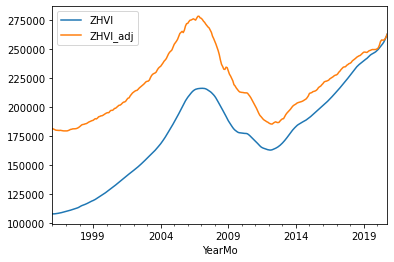

In [11]:
#Checking the trendlines for ZHVI, ZHVI_adj for the US in aggregate
us_data=trend_data2.loc[trend_data2['StateName']=='USA'].reset_index(drop=True)
print(us_data.shape)
print(us_data.head())
print(us_data.tail())
us_data.plot(x='YearMo', y=['ZHVI','ZHVI_adj'])
plt.show()
#Saw roughly the trend expected - inflation adjusting made the increase much less dramatic

In [12]:
#Calculate geometric mean inflation adjusted growth rate over the time period 
# (Jan. 1996 - Oct. 2020=298 months, 298/12 years)
geom_rr=(us_data['ZHVI_adj'].iloc[297] / us_data['ZHVI_adj'].iloc[0]) ** (12/298) - 1
print("{:.2%}".format(geom_rr))
#U.S. homes, in aggregate, returned ~1.5% appreciation after inflation over the time period

1.51%


In [13]:
#Double-checking reversibility of geometric rate of return calculation
print(181052.92 * ((1+geom_rr)**(298/12)))

262603.993662001


In [14]:
#Slice into five year chunks for the US, check distribution of rates of return over the five year chunks
us_data['one_year_later']=us_data['YearMo']+MonthEnd(12)
us_data2=us_data.merge(us_data[['YearMo','ZHVI_adj']],how='left',left_on='one_year_later',right_on='YearMo',
                      suffixes=[None,'_in_1yr']).drop('YearMo_in_1yr',axis=1)
print(us_data2.shape)
us_data2.dropna(inplace=True)
print(us_data2.shape) #confirmed - dropped 12 rows exactly (the 60 with no 5 years later entry available)
us_data2['return_1_yr']=(us_data2['ZHVI_adj_in_1yr'] / us_data2['ZHVI_adj']) - 1
us_data2.head(15)

(298, 12)
(286, 12)


,RegionType,RegionName,SizeRank,StateName,RegionID,YearMonth,ZHVI,YearMo,CPI_U,ZHVI_adj,one_year_later,ZHVI_adj_in_1yr,return_1_yr
0,Country,United States,0,USA,102001,1996-01-31,107592.0,1996-01-31,154.7,181052.924370,1997-01-31,179114.705458,-0.010705
1,Country,United States,0,USA,102001,1996-02-29,107619.0,1996-02-29,155.0,180747.846290,1997-02-28,179161.305103,-0.008778
2,Country,United States,0,USA,102001,1996-03-31,107670.0,1996-03-31,155.5,180252.043408,1997-03-31,179461.343242,-0.004387
3,Country,United States,0,USA,102001,1996-04-30,107796.0,1996-04-30,156.1,179769.338245,1997-04-30,179881.481707,0.000624
4,Country,United States,0,USA,102001,1996-05-31,107940.0,1996-05-31,156.4,179664.197570,1997-05-31,180421.993902,0.004218
5,Country,United States,0,USA,102001,1996-06-30,108109.0,1996-06-30,156.7,179600.991863,1997-06-30,180589.500000,0.005504
6,Country,United States,0,USA,102001,1996-07-31,108277.0,1996-07-31,157.0,179536.369586,1997-07-31,180908.022288,0.007640
7,Country,United States,0,USA,102001,1996-08-31,108490.0,1996-08-31,157.2,179660.682252,1997-08-31,180942.064366,0.007132
8,Country,United States,0,USA,102001,1996-09-30,108706.0,1996-09-30,157.7,179447.618580,1997-09-30,181001.776210,0.008661
9,Country,United States,0,USA,102001,1996-10-31,108964.0,1996-10-31,158.2,179305.014539,1997-10-31,181118.499381,0.010114


In [15]:
# Keeping only 1 out of every 12 entries of calculated annual return (to keep them IID)
for_analysis=us_data2.iloc[0::12]
for_analysis.head()
# Note: could run this 12 times for the 12 possible starting months and look at the distribution of p-values

,RegionType,RegionName,SizeRank,StateName,RegionID,YearMonth,ZHVI,YearMo,CPI_U,ZHVI_adj,one_year_later,ZHVI_adj_in_1yr,return_1_yr
0,Country,United States,0,USA,102001,1996-01-31,107592.0,1996-01-31,154.7,181052.924370,1997-01-31,179114.705458,-0.010705
12,Country,United States,0,USA,102001,1997-01-31,109674.0,1997-01-31,159.4,179114.705458,1998-01-31,182683.872222,0.019927
24,Country,United States,0,USA,102001,1998-01-31,113684.0,1998-01-31,162.0,182683.872222,1999-01-31,188238.525956,0.030406
36,Country,United States,0,USA,102001,1999-01-31,119093.0,1999-01-31,164.7,188238.525956,2000-01-31,194596.397224,0.033776
48,Country,United States,0,USA,102001,2000-01-31,126554.0,2000-01-31,169.3,194596.397224,2001-01-31,201357.533030,0.034744


In [16]:
# Calculate mean, standard deviation of 1-year returns, one-sided t-score that we can conclude that annual return is 
# positive
mu = for_analysis['return_1_yr'].mean()
s = (for_analysis['return_1_yr'].var(ddof=1))**0.5
n=for_analysis.shape[0]

t_stat=mu/s*(n)**0.5

p_val=2*(1 - st.t.cdf(t_stat,n-1))

print(mu, s, n, t_stat, p_val)
#print(for_analysis['return_1_yr'])

#Probability about 17.5% that the actual annual return average IS 0% post-inflation, based on our data

0.014835982282450944 0.05193979025969884 24 1.3993351241225156 0.1750552028009884


In [18]:
#Re-do the US level analysis, using monthly chunks
us_data['one_mo_later']=us_data['YearMo']+MonthEnd(1)
us_data2a=us_data.merge(us_data[['YearMo','ZHVI_adj']],how='left',left_on='one_mo_later',right_on='YearMo',
                      suffixes=[None,'_in_1mo']).drop('YearMo_in_1mo',axis=1)
print(us_data2a.shape)
us_data2a.dropna(inplace=True)
print(us_data2a.shape) #confirmed - dropped 1 row exactly (the latest row, with no 1 month return yet available)
us_data2a['return_1_mo']=(us_data2a['ZHVI_adj_in_1mo'] / us_data2a['ZHVI_adj'])**(12) - 1

# Calc t statistic and p value from the monthly returns
mu=us_data2a['return_1_mo'].mean()
s=us_data2a['return_1_mo'].std()
n=us_data2a.shape[0]
t_stat=mu/s*(n**0.5)
p_val=2*(1 - st.t.cdf(t_stat,n-1))

print(mu, s, n, t_stat)
print(p_val)

us_data2a.head(15)

(298, 13)
(297, 13)
0.0170430822143708 0.061154781629011806 297 4.802815946485451
2.4887890612834696e-06


,RegionType,RegionName,SizeRank,StateName,RegionID,YearMonth,ZHVI,YearMo,CPI_U,ZHVI_adj,one_year_later,one_mo_later,ZHVI_adj_in_1mo,return_1_mo
0,Country,United States,0,USA,102001,1996-01-31,107592.0,1996-01-31,154.7,181052.924370,1997-01-31,1996-02-29,180747.846290,-0.020034
1,Country,United States,0,USA,102001,1996-02-29,107619.0,1996-02-29,155.0,180747.846290,1997-02-28,1996-03-31,180252.043408,-0.032425
2,Country,United States,0,USA,102001,1996-03-31,107670.0,1996-03-31,155.5,180252.043408,1997-03-31,1996-04-30,179769.338245,-0.031666
3,Country,United States,0,USA,102001,1996-04-30,107796.0,1996-04-30,156.1,179769.338245,1997-04-30,1996-05-31,179664.197570,-0.006996
4,Country,United States,0,USA,102001,1996-05-31,107940.0,1996-05-31,156.4,179664.197570,1997-05-31,1996-06-30,179600.991863,-0.004213
5,Country,United States,0,USA,102001,1996-06-30,108109.0,1996-06-30,156.7,179600.991863,1997-06-30,1996-07-31,179536.369586,-0.004309
6,Country,United States,0,USA,102001,1996-07-31,108277.0,1996-07-31,157.0,179536.369586,1997-07-31,1996-08-31,179660.682252,0.008341
7,Country,United States,0,USA,102001,1996-08-31,108490.0,1996-08-31,157.2,179660.682252,1997-08-31,1996-09-30,179447.618580,-0.014139
8,Country,United States,0,USA,102001,1996-09-30,108706.0,1996-09-30,157.7,179447.618580,1997-09-30,1996-10-31,179305.014539,-0.009495
9,Country,United States,0,USA,102001,1996-10-31,108964.0,1996-10-31,158.2,179305.014539,1997-10-31,1996-11-30,179153.466919,-0.010095


In [19]:
# MSA level - overall

#Need to drop USA from this analysis still - currently counting it as a separate MSA
#Step 1 - get the min and max date entries, by MSA, and the corresponding ZHVI_adj values
msa_level=trend_data2.groupby('RegionName').agg(
    first_entry=('YearMo','min'),
    last_entry=('YearMo','max'),
    num_entries=('YearMo','count'),
    RegionID=('RegionID','mean'),
    SizeRank=('SizeRank','mean')
    ) #Note: RegionName is now the index (yay!)
msa_level2=msa_level.merge(right=trend_data2[['RegionName','YearMo','ZHVI_adj']], how='left', left_on=['RegionName',
                        'first_entry'],right_on=['RegionName','YearMo']).rename(columns={'ZHVI_adj':'ZHVI_adj_init'})
msa_level3=msa_level2.merge(right=trend_data2[['RegionName','YearMo','ZHVI_adj']], how='left', left_on=['RegionName',
                        'last_entry'],right_on=['RegionName','YearMo']).rename(columns={'ZHVI_adj':'ZHVI_adj_fin'}).drop(
                        columns=['YearMo_x','YearMo_y'])
msa_level3['geom_rr']=(msa_level3['ZHVI_adj_fin'] / msa_level3['ZHVI_adj_init']) ** (12/msa_level3['num_entries']) - 1
msa_level3.head()

,RegionName,first_entry,last_entry,num_entries,RegionID,SizeRank,ZHVI_adj_init,ZHVI_adj_fin,geom_rr
0,"Aberdeen, SD",2005-02-28,2020-10-31,189,394297,689,125966.721284,172216.0,0.020054
1,"Aberdeen, WA",2005-01-31,2020-10-31,190,394298,468,131705.971816,226016.0,0.034696
2,"Abilene, TX",2005-01-31,2020-10-31,190,394299,245,122166.609473,146467.0,0.011524
3,"Ada, OK",1996-01-31,2020-10-31,298,394300,730,71248.613445,99210.0,0.013421
4,"Adrian, MI",1996-01-31,2020-10-31,298,394302,379,127152.018908,162821.0,0.010007


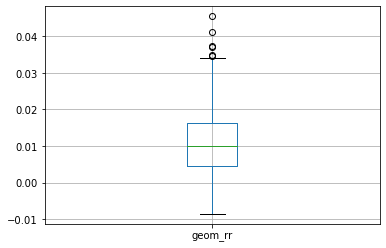

In [20]:
msa_level3.loc[msa_level3['num_entries']==298].boxplot('geom_rr')
plt.show() #Basic intuition is correct - there's some wide spread among different MSA's, with outliers at both ends
#However, when taking only those with full ~25 years of data, outliers are *substantially* fewer

In [21]:
print(msa_level3.loc[msa_level3['num_entries']==298].sort_values(by='geom_rr').head(10))
print(msa_level3.loc[msa_level3['num_entries']==298].sort_values(by='geom_rr').tail(10))

           RegionName first_entry last_entry  num_entries  RegionID  SizeRank  \
286  Forrest City, AR  1996-01-31 2020-10-31          298    394601       834   
859      Vineland, NJ  1996-01-31 2020-10-31          298    395193       258   
551    Montgomery, AL  1996-01-31 2020-10-31          298    394875       137   
659      Plymouth, IN  1996-01-31 2020-10-31          298    394987       614   
149    Charleston, WV  1996-01-31 2020-10-31          298    394455       194   
281         Flint, MI  1996-01-31 2020-10-31          298    394596       116   
275  Fayetteville, NC  1996-01-31 2020-10-31          298    394589       142   
909    Youngstown, OH  1996-01-31 2020-10-31          298    395245        93   
92    Bloomington, IL  1996-01-31 2020-10-31          298    753869       224   
782   Springfield, OH  1996-01-31 2020-10-31          298    395117       293   

     ZHVI_adj_init  ZHVI_adj_fin   geom_rr  
286   70829.602941       57241.0 -0.008541  
859  185103.359244

In [22]:
# Calculate yearly rr's for each metro area, monthly entry
trend_data2['one_year_later']=trend_data2['YearMo']+MonthEnd(12)
trend_data3=trend_data2.merge(trend_data2[['YearMo','RegionID','ZHVI_adj']],how='left',left_on=['RegionID','one_year_later'],
                              right_on=['RegionID','YearMo'],suffixes=[None,'_in_1yr']).drop('YearMo_in_1yr',axis=1)
print(trend_data3.shape)
trend_data3.dropna(inplace=True)
print(trend_data3.shape) #Dropped about 11,000 - makes sense for 12 entries * many MSA's
trend_data3['return_1_yr']=(trend_data3['ZHVI_adj_in_1yr'] / trend_data3['ZHVI_adj']) - 1
trend_data3.loc[trend_data3['RegionName']=='Dallas-Fort Worth, TX'].head(15)

(220515, 12)
(209547, 12)


,RegionType,RegionName,SizeRank,StateName,RegionID,YearMonth,ZHVI,YearMo,CPI_U,ZHVI_adj,one_year_later,ZHVI_adj_in_1yr,return_1_yr
4,Msa,"Dallas-Fort Worth, TX",4,TX,394514,1996-01-31,113386.0,1996-01-31,154.7,190802.911765,1997-01-31,189828.206085,-0.005108
434,Msa,"Dallas-Fort Worth, TX",4,TX,394514,1996-02-29,113451.0,1996-02-29,155.0,190542.784355,1997-02-28,189624.837821,-0.004818
866,Msa,"Dallas-Fort Worth, TX",4,TX,394514,1996-03-31,113613.0,1996-03-31,155.5,190201.313344,1997-03-31,189551.787860,-0.003415
1299,Msa,"Dallas-Fort Worth, TX",4,TX,394514,1996-04-30,113937.0,1996-04-30,156.1,190010.567104,1997-04-30,189708.384146,-0.001590
1732,Msa,"Dallas-Fort Worth, TX",4,TX,394514,1996-05-31,114286.0,1996-05-31,156.4,190227.000959,1997-05-31,189863.048780,-0.001913
2169,Msa,"Dallas-Fort Worth, TX",4,TX,394514,1996-06-30,114538.0,1996-06-30,156.7,190281.460434,1997-06-30,189827.625000,-0.002385
2607,Msa,"Dallas-Fort Worth, TX",4,TX,394514,1996-07-31,114718.0,1996-07-31,157.0,190216.327070,1997-07-31,189969.085100,-0.001300
3046,Msa,"Dallas-Fort Worth, TX",4,TX,394514,1996-08-31,114941.0,1996-08-31,157.2,190343.612118,1997-08-31,189909.354011,-0.002281
3485,Msa,"Dallas-Fort Worth, TX",4,TX,394514,1996-09-30,115166.0,1996-09-30,157.7,190111.534242,1997-09-30,189922.590726,-0.000994
3925,Msa,"Dallas-Fort Worth, TX",4,TX,394514,1996-10-31,115507.0,1996-10-31,158.2,190071.806416,1997-10-31,190122.681734,0.000268


In [23]:
# Keep only the january entries, calculate mu, n, s, t-stat, and p value of the yearly return
for_msa_analysis=trend_data3.loc[trend_data3['YearMo'].dt.month==1].groupby('RegionName').agg(
    mu=('return_1_yr','mean'),
    n=('return_1_yr','count'),
    s=('return_1_yr','std') #Should use ddof=1 by default, per pandas documentation
    )
for_msa_analysis['t_stat']=for_msa_analysis['mu']/for_msa_analysis['s']*(for_msa_analysis['n'])**0.5
for_msa_analysis['p_value']=for_msa_analysis.apply(lambda x: 2*min(1 - st.t.cdf(x['t_stat'],x['n']-1), 
                                                               st.t.cdf(x['t_stat'],x['n']-1)), axis=1)
for_msa_analysis.rename(columns={'mu':'avg_rr'},inplace=True)
print(for_msa_analysis.shape)
for_msa_analysis.head()

(914, 5)


,avg_rr,n,s,t_stat,p_value
RegionName,,,,,
"Aberdeen, SD",0.018309,14,0.025095,2.729911,0.017185
"Aberdeen, WA",0.030000,15,0.083437,1.392561,0.185476
"Abilene, TX",0.010103,15,0.034897,1.121267,0.281039
"Ada, OK",0.013816,24,0.035132,1.926541,0.066482
"Adrian, MI",0.010448,24,0.057015,0.897717,0.378638


In [24]:
trend_data2['one_mo_later']=trend_data2['YearMo']+MonthEnd(1)
trend_data3a=trend_data2.merge(trend_data2[['YearMo','RegionID','ZHVI_adj']],how='left',left_on=['RegionID','one_mo_later'],
                              right_on=['RegionID','YearMo'],suffixes=[None,'_in_1mo']).drop('YearMo_in_1mo',axis=1)
print(trend_data3a.shape)
trend_data3a.dropna(inplace=True)
print(trend_data3a.shape) #Dropped about 11,000 - makes sense for 12 entries * many MSA's
trend_data3a['return_1_mo']=(trend_data3a['ZHVI_adj_in_1mo'] / trend_data3a['ZHVI_adj'])**12 - 1
print(trend_data3a.loc[trend_data3a['RegionName']=='Dallas-Fort Worth, TX'].head())

msa_analysis2=trend_data3a.groupby('RegionName').agg(
    mu=('return_1_mo','mean'),
    n=('return_1_mo','count'),
    s=('return_1_mo','std') #Should use ddof=1 by default, per pandas documentation
    )
msa_analysis2['t_stat']=msa_analysis2['mu']/msa_analysis2['s']*(msa_analysis2['n'])**0.5
msa_analysis2['p_value_1mo']=msa_analysis2.apply(lambda x: 2*min(1 - st.t.cdf(x['t_stat'],x['n']-1), 
                                                               st.t.cdf(x['t_stat'],x['n']-1)), axis=1)
msa_analysis2.rename(columns={'mu':'avg_rr_1mo'},inplace=True)
print(msa_analysis2.head())
print(msa_analysis2.loc['Chicago, IL'])

(220515, 13)
(219601, 13)
     RegionType             RegionName  SizeRank StateName  RegionID  \
4           Msa  Dallas-Fort Worth, TX         4        TX    394514   
434         Msa  Dallas-Fort Worth, TX         4        TX    394514   
866         Msa  Dallas-Fort Worth, TX         4        TX    394514   
1299        Msa  Dallas-Fort Worth, TX         4        TX    394514   
1732        Msa  Dallas-Fort Worth, TX         4        TX    394514   

       YearMonth      ZHVI     YearMo  CPI_U       ZHVI_adj one_year_later  \
4     1996-01-31  113386.0 1996-01-31  154.7  190802.911765     1997-01-31   
434   1996-02-29  113451.0 1996-02-29  155.0  190542.784355     1997-02-28   
866   1996-03-31  113613.0 1996-03-31  155.5  190201.313344     1997-03-31   
1299  1996-04-30  113937.0 1996-04-30  156.1  190010.567104     1997-04-30   
1732  1996-05-31  114286.0 1996-05-31  156.4  190227.000959     1997-05-31   

     one_mo_later  ZHVI_adj_in_1mo  return_1_mo  
4      1996-02-29    1

In [25]:
msa_level4=msa_level3.merge(right=for_msa_analysis[['avg_rr','p_value']],on='RegionName')
msa_level4=msa_level4.merge(right=msa_analysis2[['avg_rr_1mo','p_value_1mo']],on='RegionName')
msa_level4.head()

,RegionName,first_entry,last_entry,num_entries,RegionID,SizeRank,ZHVI_adj_init,ZHVI_adj_fin,geom_rr,avg_rr,p_value,avg_rr_1mo,p_value_1mo
0,"Aberdeen, SD",2005-02-28,2020-10-31,189,394297,689,125966.721284,172216.0,0.020054,0.018309,0.017185,0.021310,1.330790e-08
1,"Aberdeen, WA",2005-01-31,2020-10-31,190,394298,468,131705.971816,226016.0,0.034696,0.030000,0.185476,0.039919,2.645294e-07
2,"Abilene, TX",2005-01-31,2020-10-31,190,394299,245,122166.609473,146467.0,0.011524,0.010103,0.281039,0.013274,2.390574e-03
3,"Ada, OK",1996-01-31,2020-10-31,298,394300,730,71248.613445,99210.0,0.013421,0.013816,0.066482,0.015860,1.311164e-04
4,"Adrian, MI",1996-01-31,2020-10-31,298,394302,379,127152.018908,162821.0,0.010007,0.010448,0.378638,0.012475,2.100969e-03


In [26]:
#Getting only those with full data, p values<=0.05
msa_level5=msa_level4.loc[(msa_level4['num_entries']==298) & (msa_level4['RegionID']!=102001)]
#&   (msa_level4['p_value_1mo']<=0.05)]
print(msa_level5.shape)
print(msa_level5.sort_values('geom_rr').head(20))
print(msa_level5.sort_values('geom_rr').tail(10))
#print(msa_level5.loc[msa_level5['SizeRank']<=20])

(429, 13)
           RegionName first_entry last_entry  num_entries  RegionID  SizeRank  \
286  Forrest City, AR  1996-01-31 2020-10-31          298    394601       834   
859      Vineland, NJ  1996-01-31 2020-10-31          298    395193       258   
551    Montgomery, AL  1996-01-31 2020-10-31          298    394875       137   
659      Plymouth, IN  1996-01-31 2020-10-31          298    394987       614   
149    Charleston, WV  1996-01-31 2020-10-31          298    394455       194   
281         Flint, MI  1996-01-31 2020-10-31          298    394596       116   
275  Fayetteville, NC  1996-01-31 2020-10-31          298    394589       142   
909    Youngstown, OH  1996-01-31 2020-10-31          298    395245        93   
92    Bloomington, IL  1996-01-31 2020-10-31          298    753869       224   
782   Springfield, OH  1996-01-31 2020-10-31          298    395117       293   
502     Mansfield, OH  1996-01-31 2020-10-31          298    394824       325   
96    Blytheville,

In [201]:
print(msa_level4.loc[msa_level4['RegionName'].isin(['Chicago, IL','Dallas-Fort Worth, TX','San Francisco, CA',
                                                   'Los Angeles-Long Beach-Anaheim, CA','New York, NY'])])

                             RegionName first_entry last_entry  num_entries  \
154                         Chicago, IL  1996-01-31 2020-10-31          298   
201               Dallas-Fort Worth, TX  1996-01-31 2020-10-31          298   
482  Los Angeles-Long Beach-Anaheim, CA  1996-01-31 2020-10-31          298   
589                        New York, NY  1996-01-31 2020-10-31          298   
727                   San Francisco, CA  1996-01-31 2020-10-31          298   

     RegionID  SizeRank  ZHVI_adj_init  ZHVI_adj_fin   geom_rr    avg_rr  \
154    394463         3  276139.701681      255532.0 -0.003118 -0.002661   
201    394514         4  190802.911765      271831.0  0.014355  0.013802   
482    753899         2  312110.659664      726379.0  0.034600  0.038268   
589    394913         1  317827.039916      505569.0  0.018867  0.019725   
727    395057        11  414226.380252     1126793.0  0.041120  0.045663   

      p_value  avg_rr_1mo   p_value_1mo  
154  0.843263    0.000133 

In [223]:
# Importing the DQYDJ dataset, merging on inflation adjustment to 2020 dollars
sp500=pd.read_csv('./datasets/sp500_div_reinv_nonadj_Jan1996_Oct2020.csv')[['Date','Current Portfolio Value']]
sp500['Year']=sp500['Date'].astype(int)
sp500['Month']=sp500['Date']%1.0 * 100
sp500['Day']=np.ones(sp500.shape[0])
sp500['YearMo']=pd.to_datetime(sp500[['Year','Month','Day']])+MonthEnd(1)
sp500.drop(columns=['Date','Year','Month','Day'],inplace=True)

sp500=sp500.merge(right=inflation_df[['YearMo','CPI_U']],on='YearMo')
cpi_u_curr = inflation_df['CPI_U'].iloc[-1]
print(cpi_u_curr)
sp500['Val_Adj']=sp500['Current Portfolio Value']*cpi_u_curr/sp500['CPI_U'] #Adjusting all values to current dollars
sp500['Val_Adj_Norm']=sp500['Val_Adj']*1e5 / sp500['Val_Adj'].iloc[0]
sp500.head()

260.325


,Current Portfolio Value,YearMo,CPI_U,Val_Adj,Val_Adj_Norm
0,100000.000000,1996-01-31,154.7,168277.310924,100000.000000
1,105847.414269,1996-02-29,155.0,177772.439481,105642.548306
2,105577.833446,1996-03-31,155.5,176749.514417,105034.667744
3,105727.892192,1996-04-30,156.1,176320.394201,104779.659975
4,108158.785536,1996-05-31,156.4,180028.362178,106983.146562


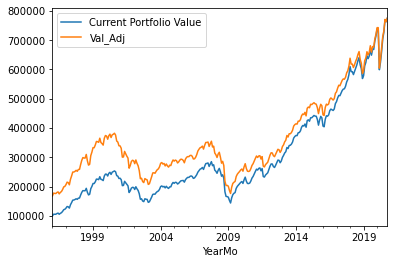

In [183]:
sp500.plot(x='YearMo', y=['Current Portfolio Value','Val_Adj'])

# Making the visualizations for report

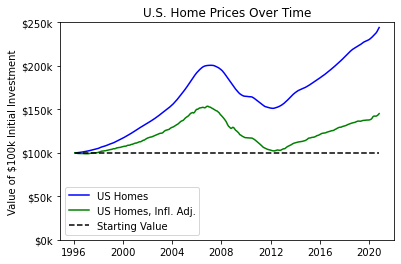

In [224]:
# First Viz: Indexed to a $100k starting value, show US home prices w/ and without inflation adjustment
ZHVI_start=us_data['ZHVI'].iloc[0]
ZHVI_adj_start=us_data['ZHVI_adj'].iloc[0]
us_data['ZHVI_normed']=us_data['ZHVI']/ZHVI_start * 1e5
us_data['ZHVI_adj_normed']=us_data['ZHVI_adj']/ZHVI_adj_start * 1e5
starting_line=np.ones(us_data.shape[0])*1e5

plt.plot('YearMo', 'ZHVI_normed','b',data=us_data,label='US Homes')
plt.plot('YearMo', 'ZHVI_adj_normed','g',data=us_data,label='US Homes, Infl. Adj.')
plt.plot(us_data.YearMo.values, starting_line,'k--',label='Starting Value')
plt.ylim([0,2.5e5])
plt.ylabel('Value of $100k Initial Investment')
plt.title('U.S. Home Prices Over Time')
plt.gca().set_yticklabels(['${:,.0f}k'.format(y/1000) for y in plt.gca().get_yticks()]) 
plt.legend()

plt.savefig('Home_Prices.png',format='png')

plt.show()

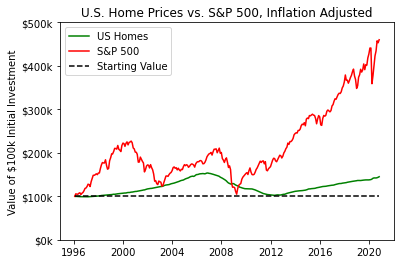

In [241]:
# Second Viz: Add S&P 500 with inflation adjusting for comparison
plt.plot('YearMo', 'ZHVI_adj_normed','g',data=us_data,label='US Homes')
plt.plot('YearMo', 'Val_Adj_Norm','r',data=sp500, label='S&P 500')
plt.plot(us_data.YearMo.values, starting_line,'k--',label='Starting Value')
plt.ylim([0,5e5])
plt.ylabel('Value of $100k Initial Investment')
plt.title('U.S. Home Prices vs. S&P 500, Inflation Adjusted')
plt.gca().set_yticklabels(['${:,.0f}k'.format(y/1000) for y in plt.gca().get_yticks()]) 
plt.legend()

plt.savefig('Home_Prices_v_S&P.png',format='png')

plt.show()

In [235]:
# Third Viz: Visualize across top 4 metros vs. the US as a whole
nyc_data=trend_data2.loc[trend_data2['RegionName']=='New York, NY'].copy()
nyc_data['val_norm']=nyc_data['ZHVI_adj']*1e5 / nyc_data['ZHVI_adj'].iloc[0]
chi_data=trend_data2.loc[trend_data2['RegionName']=='Chicago, IL'].copy()
chi_data['val_norm']=chi_data['ZHVI_adj']*1e5 / chi_data['ZHVI_adj'].iloc[0]
la_data=trend_data2.loc[trend_data2['RegionName']=='Los Angeles-Long Beach-Anaheim, CA'].copy()
la_data['val_norm']=la_data['ZHVI_adj']*1e5 / la_data['ZHVI_adj'].iloc[0]
dfw_data=trend_data2.loc[trend_data2['RegionName']=='Dallas-Fort Worth, TX'].copy()
dfw_data['val_norm']=dfw_data['ZHVI_adj']*1e5 / dfw_data['ZHVI_adj'].iloc[0]

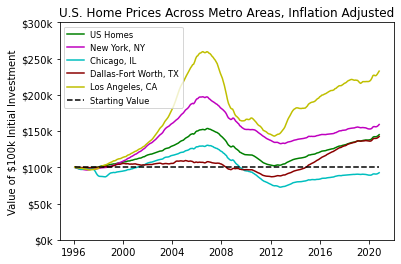

In [246]:
plt.plot('YearMo', 'ZHVI_adj_normed','g',data=us_data,label='US Homes')
plt.plot('YearMo', 'val_norm','m',data=nyc_data,label='New York, NY')
plt.plot('YearMo', 'val_norm','c',data=chi_data,label='Chicago, IL')
plt.plot('YearMo', 'val_norm','darkred',data=dfw_data,label='Dallas-Fort Worth, TX')
plt.plot('YearMo', 'val_norm','y',data=la_data,label='Los Angeles, CA')

#plt.plot('YearMo', 'Val_Adj_Norm','r',data=sp500, label='S&P 500, Infl. Adj.')
plt.plot(us_data.YearMo.values, starting_line,'k--',label='Starting Value')
plt.ylim([0,3e5])
plt.ylabel('Value of $100k Initial Investment')
plt.title('U.S. Home Prices Across Metro Areas, Inflation Adjusted')
plt.gca().set_yticklabels(['${:,.0f}k'.format(y/1000) for y in plt.gca().get_yticks()]) 
plt.legend(fontsize='small')

plt.savefig('Home_Prices_Across_Metros.png',format='png')

plt.show()

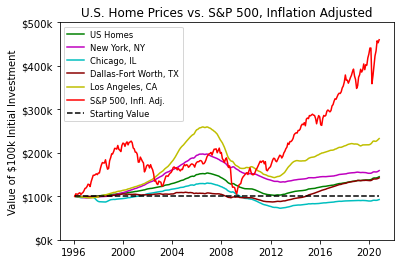

In [248]:
# Final Viz: Multiple Metros, Incl S&P for comparison
plt.plot('YearMo', 'ZHVI_adj_normed','g',data=us_data,label='US Homes')
plt.plot('YearMo', 'val_norm','m',data=nyc_data,label='New York, NY')
plt.plot('YearMo', 'val_norm','c',data=chi_data,label='Chicago, IL')
plt.plot('YearMo', 'val_norm','darkred',data=dfw_data,label='Dallas-Fort Worth, TX')
plt.plot('YearMo', 'val_norm','y',data=la_data,label='Los Angeles, CA')

plt.plot('YearMo', 'Val_Adj_Norm','r',data=sp500, label='S&P 500, Infl. Adj.')
plt.plot(us_data.YearMo.values, starting_line,'k--',label='Starting Value')
plt.ylim([0,5e5])
plt.ylabel('Value of $100k Initial Investment')
plt.title('U.S. Home Prices vs. S&P 500, Inflation Adjusted')
plt.gca().set_yticklabels(['${:,.0f}k'.format(y/1000) for y in plt.gca().get_yticks()]) 
plt.legend(fontsize='small')

plt.savefig('Home_Prices_Across_Metros_w_S&P.png',format='png')

plt.show()